In [12]:
# Workspace problem with several narrow gaps

import torch
import torch.nn as nn

from functools import partial
import numpy as np
from numpy.random import default_rng
from io import StringIO
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.ndimage import uniform_filter1d
import matplotlib.animation as animation
import matplotlib.patches as patches
import sys
import time
import cv2
from celluloid import Camera
from IPython.display import HTML

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

rng = default_rng(900)

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [2]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512*6 # encoder dim
h_P_dim = 512*6 # decoder dim

# problem dimenc_dimsions
nDrawnSamples = 49 # number of dependent samples to draw during smapling (length of predicted control series)
nPreviousStates = 1 # number of previous states to condition on the steering prediction
dim = 7 # (truckX, truckY, truckYaw, truckX, trailerY, trailerYaw, steer)
dimGoal = 3
dimObs = 3*2
dimPredict = dim - 0 # predict truck (truckX, truckY, truckYaw, steer)
dataElements = (nDrawnSamples + nPreviousStates) * dim + dimGoal + dimObs # steer sample, current pose (3D: x,y,yaw), goal (3D), dimObs (2D x 3)

z_dim = 3 # latent dim
X_dim = nDrawnSamples*dimPredict
c_dim = dataElements - X_dim # dimension of conditioning variable

gridSize = 11

In [3]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:

            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))

            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y


network = torch.load('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/networks/roadgrid_49.pt', map_location=torch.device(DEVICE))

In [4]:
# read in data from .txt file, re-arrange to allow drawing multiple depedent samples

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/motion_planning/data/mapD_data_27kPlans'
rawdata = np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[0,1,2,3,4,5,6,10,11,12,13,14,15,16,17,18]) # disregard init

_, pathsIdx = np.unique(rawdata[:,dim:], axis=0, return_index=True)
pathsIdx.sort()

pathsLengths = np.roll(pathsIdx, -1) - pathsIdx
pathsLengths[-1] = rawdata.shape[0] - np.sum(pathsLengths[:-1])

validLengthsIdx = np.argwhere(pathsLengths >= nPreviousStates + nDrawnSamples) 
validPlansIdx = pathsIdx[validLengthsIdx]

data = np.zeros(shape=(1, dataElements)) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
tempdata = np.copy(data)
for ci, i in enumerate(validPlansIdx[:-1].reshape(-1)):
    for j in range(pathsLengths[ci] - (nPreviousStates + nDrawnSamples - 1)):
        sample = np.arange(start=j, stop=j + nPreviousStates + nDrawnSamples)

        if np.any(np.abs(np.diff(rawdata[i + sample, 0])) > 0.05) or np.any(np.abs(np.diff(rawdata[i + sample, 1])) > 0.05):
            break # ignore duplicate plans (data generation is not perfect)
        
        seqstates = rawdata[i + sample, :dim].reshape(1, (nPreviousStates + nDrawnSamples)*dim)
        # filter out paths that has near zero steering input
        if np.where(np.abs(seqstates[0, 4:(nPreviousStates + nDrawnSamples)*dim:dim]) < 3e-2)[0].shape[0] >= (nDrawnSamples + nPreviousStates) // 1.2:
            continue

        tempdata = np.vstack((tempdata, np.append(seqstates, rawdata[i, dim:].reshape(1, dimGoal+dimObs), axis=1))) 
        # smoothen steering
        tempdata[-1, 4:(nPreviousStates + nDrawnSamples)*dim:dim] = uniform_filter1d(np.poly1d(np.polyfit(np.arange(nPreviousStates + nDrawnSamples), tempdata[-1, 4:(nPreviousStates + nDrawnSamples)*dim:dim], 9))(np.arange(nPreviousStates + nDrawnSamples)), size=7, origin=0, mode='nearest', axis=0)

        if ci % 500 == 0:
            data = np.vstack((data, tempdata[1:]))
            tempdata = np.zeros(shape=(1, dataElements))

data = data[1:]

rng.shuffle(data) # shuffle data (otherwise the data is sorted by obstacles/the map)

pathData = np.copy(data[:, :-dimObs])
obsData = np.copy(data[:, -dimObs:])

numEntries = pathData.shape[0]
print(numEntries)

51202


In [5]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)

ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

x = pathData[:, dim * nPreviousStates:-dim+1:dim]
y = pathData[:, 1 + dim * nPreviousStates:-dim+2:dim]
yaw = pathData[:, 2 + dim * nPreviousStates:-dim+3:dim]
steer = pathData[:, 4 + dim * nPreviousStates:-dim+5:dim]
tx = pathData[:, 5 + dim * nPreviousStates:-dim+6:dim]
ty = pathData[:, 6 + dim * nPreviousStates:-dim+6:dim]
tyaw = pathData[:, 3 + dim * nPreviousStates:-dim+4:dim]

X = np.zeros(shape=(numEntries, X_dim))
X[:, ::dimPredict] = x
X[:, 1::dimPredict] = y
X[:, 2::dimPredict] = yaw
X[:, 3::dimPredict] = steer
X[:, 4::dimPredict] = ty
X[:, 5::dimPredict] = tx
X[:, 6::dimPredict] = tyaw

X_train = X[:numTrain]
X_test = X[numTrain:numEntries]

numTest = X_test.shape[0]

print(X_train.shape)

(40961, 343)


In [6]:
# generate conditioning variable

nextStates = pathData[:, nPreviousStates*dim:-dimGoal]

prevStatesConditions = pathData[:, :nPreviousStates * dim]
goalStateCondition = pathData[:, -dimGoal:]

conditionsOcc = np.zeros(shape=(numEntries, gridSize ** 2))
for i, row in enumerate(obsData):
    occGrid = np.zeros(shape=[gridSize, gridSize])
    VRT = row[:dimObs//2]
    HOR = row[dimObs//2:]
    occGrid[:, (VRT * (gridSize - 1)).astype(int)] = 1
    occGrid[((1 - HOR) * (gridSize - 1)).astype(int), :] = 1

    conditionsOcc[i] = occGrid.reshape(-1)

cs = np.concatenate((prevStatesConditions, goalStateCondition, conditionsOcc), axis=1)

c_train = cs[0:numTrain,:]  
c_test = cs[numTrain:numEntries,:]

print(cs.shape)

(51202, 131)


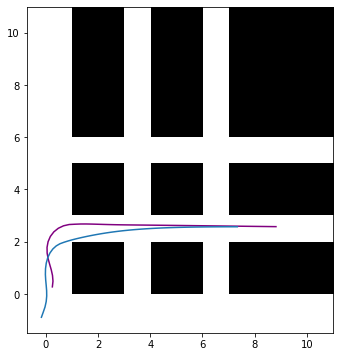

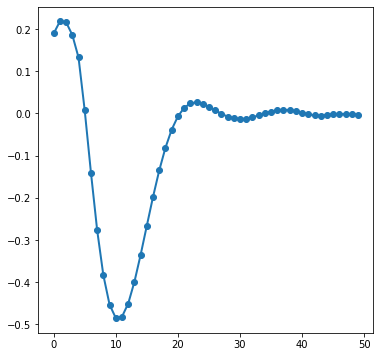

In [7]:
# Visualize random data sample

plt.figure(figsize=(6,6))
i = np.random.randint(1,numEntries)
plt.imshow(cs[i, -gridSize ** 2:].reshape(gridSize, gridSize), extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.plot(pathData[i, :-dim:dim] * gridSize, pathData[i, 1:-dim:dim] * gridSize, color='purple')
plt.plot(pathData[i, 5:-dim:dim] * gridSize, pathData[i, 6:-dim:dim] * gridSize, color='C0')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(np.arange(nPreviousStates + nDrawnSamples), pathData[i, 4:-dim+4:dim], 'o-', linewidth=2)
plt.show()

In [7]:
# define planning problem

def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(4.0))
     return obj


def isRV2StateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    u = int(np.floor(state[0] * gridSize)) # right pointing image axis
    v = int(np.floor(gridSize * (1 - state[1]))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0


def problemDef():

    # construct the state space we are planning in
    space = ob.RealVectorStateSpace(2)

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.001)
    bounds.setHigh(0.999)
    space.setBounds(bounds)

    # define a simple setup class
    ss = og.SimpleSetup(space)
    si = ss.getSpaceInformation()
    planner = og.RRTstar(si)

    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isRV2StateValid, ss.getSpaceInformation())))

    ss.setPlanner(planner)
    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))
    
    return ss


def plan(planObj, initState, goalState):
 
    space = ob.RealVectorStateSpace(2)

    start = ob.State(space)
    start[0] = initState[0]
    start[1] = initState[1]

    goal = ob.State(space)
    goal[0] = goalState[0]
    goal[1] = goalState[1]

    planObj.setStartAndGoalStates(start, goal, 0.02)

    timeTerminationCondition = ob.timedPlannerTerminationCondition(2.)

    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), solutionsWindow=4, epsilon=1.0)

    solved = planObj.solve(ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition))

    if solved:
        planObj.simplifySolution()

In [8]:
class VehicleState():
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.v = 0

saving animation


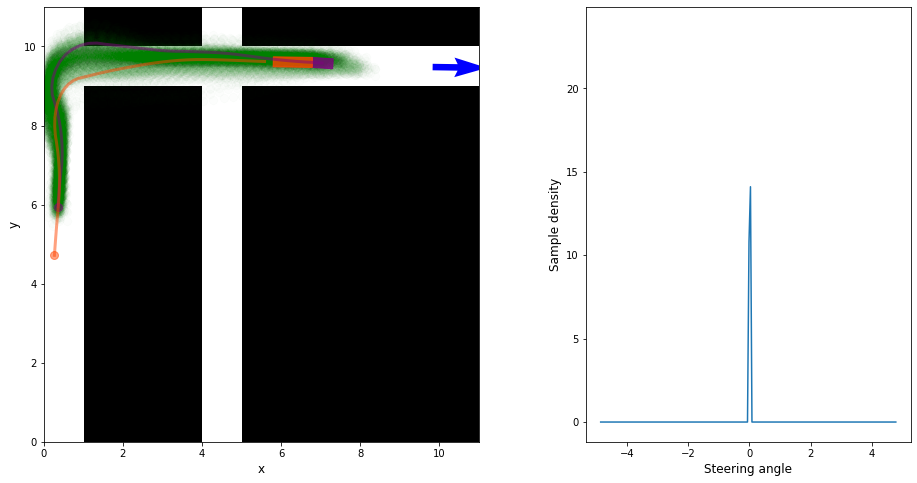

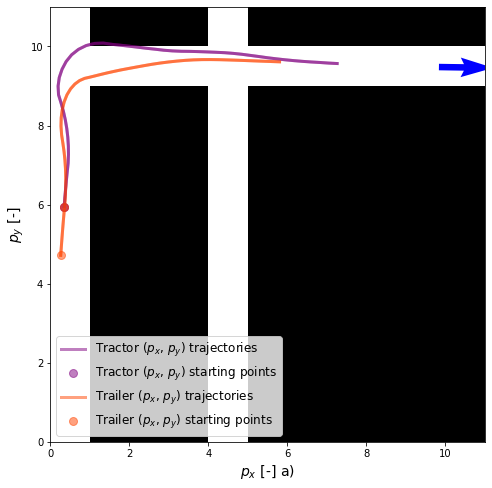

In [30]:
# Use random start states

# generate planning scenario, plan, and perform path following

minDistThreshold = 0.7 # minimum distance threshold betwen start/goal
nLatSamples = 400 # number of samples to draw in latent space (when using nn)
p = 0.8 # likelihood which to sample from NN samples (when useNN is True)
nCtrlIter = 49
nPredictCtrlSteps = 49 # number of steps to simulate the car for using a single prediction


dt = 0.2
v =  0.1 # vehicle speed
L   = 0.05 # vehicle length constant
W   = 0.023 # truck/trailer width
Lt  = 0.18 # truck length constant
a11 = 0.5 * L
a12 = L - a11
b1  = 0.9 * a12
b2  = 0.5 * Lt 
a21 = Lt - b2

planIdx = np.random.randint(numTrain, numEntries - 1)
goal = data[planIdx, -dimObs-dimGoal:-dimObs]
start = data[planIdx, :dim]

occGrid = conditionsOcc[planIdx].reshape(gridSize, gridSize)
intersectGrid = np.ones(shape=occGrid.shape)
VRT, HOR = obsData[planIdx, :dimObs//2], obsData[planIdx, dimObs//2:]
VRTv, HORv = np.meshgrid((VRT * (gridSize - 1)).astype(int), ((1 - HOR) * (gridSize - 1)).astype(int), indexing='ij')
intersectGrid[HORv.reshape(-1), VRTv.reshape(-1)] = 0
intersectGrid = np.floor(cv2.blur(intersectGrid, ksize=(3,3)))

maxSteer = np.max(data[:, 3::dim])
minSteer = np.min(data[:, 3::dim])
steerAngles = np.linspace(minSteer, maxSteer, num=200)

nStarts = 1 # number of random initial conditions
statearr = np.zeros(shape=(nCtrlIter + 1, dim, nStarts))

animate = True
for i in range(nStarts):

    # --- choose random initial state ---
    pdef = problemDef()

    # while True:
        
    #     while True: # randomize starting coordinates
    #         start = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
            
    #         uStart = int(np.floor(start[0] * gridSize)) # right pointing image axis
    #         vStart = int(np.floor(gridSize * (1 - start[1]))) # down pointing image axis
    #         if np.abs(start[:2] - goal[:2]).sum() > minDistThreshold and occGrid[vStart,uStart] > 0 and intersectGrid[vStart,uStart] > 0:
    #             break

    #     pdef.clear()
    #     plan(pdef, initState=start, goalState=goal)
    #     if pdef.getProblemDefinition().hasExactSolution():
    #         break

    # ssol = np.loadtxt(StringIO(pdef.getProblemDefinition().getSolutionPath().printAsMatrix()))

    # # remove points unneccesarily close to start/goal
    # ssol = ssol[1:] if np.linalg.norm(ssol[0, :2] - start[:2]) < 0.02 else ssol
    # ssol = ssol[:-1] if np.linalg.norm(ssol[-1, :2] - goal[:2]) < 0.02 else ssol

    # if ssol.shape[0] > 0:
    #     # find suitable starting yaw 
    #     start_dxdy = ssol[0, :2] - start[:2]
    #     start_xydot = start_dxdy / np.linalg.norm(start_dxdy)
    #     start[-1] = np.sign(int(start_xydot[-1] > 0) - 0.5) * np.arccos(np.dot(start_xydot / np.linalg.norm(start_xydot), [1, 0])) # get yaw from xdot, ydot
    # else:
    #     continue
    # ----------------------------------------
    
    truckState = VehicleState()
    truckState.x = start[0]; truckState.y = start[1]; truckState.yaw = start[2]; truckState.v = v

    trailerState = VehicleState()
    trailerState.yaw = truckState.yaw
    trailerState.x = truckState.x - b1 * np.cos(truckState.yaw) - b2 * np.cos(trailerState.yaw)
    trailerState.y = truckState.y - b1 * np.sin(truckState.yaw) - b2 * np.sin(trailerState.yaw)

    statearr[0, :, i] = np.array([truckState.x, truckState.y, truckState.yaw, trailerState.yaw, 0, trailerState.x, trailerState.y])

    if animate:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), gridspec_kw={'width_ratios': [3, 2]})
        camera = Camera(fig)

    nStepsFromPrediction = 0 # number of steps taken so far given last CVAE prediction
    for ctrlIter in range(nCtrlIter):
        currentState = statearr[ctrlIter, :, i]

        if nStepsFromPrediction % nPredictCtrlSteps == 0:
            nStepsFromPrediction = 0 # number of steps taken so far given last CVAE prediction
            
            condition = torch.from_numpy(np.repeat([np.concatenate((currentState, goal, conditionsOcc[planIdx]))], nLatSamples, axis=0)).float().to(DEVICE)
            predictedStates = network(torch.randn(nLatSamples, z_dim).to(DEVICE), condition, encode=False).cpu().detach().numpy()

            kdes = np.array([gaussian_kde(predictedStates[:, i * dim - 4]) for i in range(1, nPredictCtrlSteps + 1)])

        delta = steerAngles[np.argmax(kdes[nStepsFromPrediction].pdf(steerAngles))]

        if animate:
            truckX = statearr[:ctrlIter+1, ::dim, i] * gridSize
            truckY = statearr[:ctrlIter+1, 1::dim, i] * gridSize
            trailerX = statearr[:ctrlIter+1, dim-2::dim, i] * gridSize
            trailerY = statearr[:ctrlIter+1, dim-1::dim, i] * gridSize

            ax1.plot(truckX, truckY, color="purple", linewidth=3, alpha=0.5)
            ax1.plot(truckX[0], truckY[0], 'o', color="purple", markersize=8, alpha=0.5)
            ax1.plot(trailerX, trailerY, color="orangered", linewidth=3, alpha=0.5)
            ax1.plot(trailerX[0], trailerY[0], 'o', color="orangered", markersize=8, alpha=0.5)
            ax1.scatter(predictedStates[:,::dim] * gridSize, predictedStates[:,1::dim] * gridSize, color='green', s=70, alpha=0.01) # nn samples
            rectTruck = patches.Rectangle(((truckState.x - np.cos(truckState.yaw) * L/2 + np.sin(truckState.yaw) * W/2) * gridSize, 
                        (truckState.y - np.cos(truckState.yaw) * W/2 - np.sin(truckState.yaw) * L/2) * gridSize), L * gridSize, W * gridSize, angle=np.rad2deg(truckState.yaw), color='purple', alpha=0.8, label='Vehicle')
            rectTrailer = patches.Rectangle(((truckState.x - b1 * np.cos(truckState.yaw) - b2 / 2 * np.cos(trailerState.yaw) - np.cos(trailerState.yaw) * b2/2 + np.sin(trailerState.yaw) * W/2) * gridSize, 
                        (truckState.y - b1 * np.sin(truckState.yaw) - b2 / 2 * np.sin(trailerState.yaw) - np.cos(trailerState.yaw) * W/2 - np.sin(trailerState.yaw) * b2/2) * gridSize), b2 * gridSize, W * gridSize, angle=np.rad2deg(trailerState.yaw), color='orangered', alpha=0.8, label='Trailer')
            ax1.add_patch(rectTruck)
            ax1.add_patch(rectTrailer)
            ax1.quiver(goal[0] * gridSize, goal[1] * gridSize, np. cos(goal[2]), np.sin(goal[2]), color='blue', scale=8.0, width=0.015)
            ax1.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
            ax1.set_xlabel('x', fontsize=12)
            ax1.set_ylabel('y', fontsize=12)
            ax2.plot(steerAngles, kdes[nStepsFromPrediction].pdf(steerAngles), color='C0')
            ax2.set_xlabel('Steering angle', fontsize=12)
            ax2.set_ylabel('Sample density', fontsize=12)
            camera.snap()

        beta = np.arctan(np.tan(delta) * a12 / (a11 + a12))

        trailerState.x = truckState.x - b1 * np.cos(truckState.yaw) - b2 * np.cos(trailerState.yaw)
        trailerState.y = truckState.y - b1 * np.sin(truckState.yaw) - b2 * np.sin(trailerState.yaw)
        trailerState.yaw += (v * np.sin(truckState.yaw - trailerState.yaw) / (b2 + a21) - v * (b1 - a12) * np.cos(truckState.yaw - trailerState.yaw) * np.sin(beta) / (a12 * (b2 + a21))) * dt

        truckState.x += v * np.cos(truckState.yaw + beta) * dt
        truckState.y += v * np.sin(truckState.yaw + beta) * dt
        truckState.yaw += v * np.sin(beta) / a12 * dt

        statearr[ctrlIter+1, :, i] = np.array([truckState.x, truckState.y, truckState.yaw, trailerState.yaw, delta, trailerState.x, trailerState.y])
        nStepsFromPrediction += 1

    if animate:        
        fps = 20
        animation = camera.animate(interval=2000/fps)
        print("saving animation")
        animation.save('animation.mp4')

fig = plt.figure(figsize=(8,8))
plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np. cos(goal[2]), np.sin(goal[2]), color='blue', scale=8.0, width=0.015)
plt.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.xlabel('$p_x$ [-] a)', fontsize=14)
plt.ylabel('$p_y$ [-]', fontsize=14)
for i in range(nStarts):
    truckX = statearr[:, ::dim, i] * gridSize
    truckY = statearr[:, 1::dim, i] * gridSize
    trailerX = statearr[:, dim-2::dim, i] * gridSize
    trailerY = statearr[:, dim-1::dim, i] * gridSize
    plt.plot(truckX, truckY, color="purple", linewidth=3, alpha=0.5)
    plt.plot(truckX[0], truckY[0], 'o', color="purple", markersize=8, alpha=0.5)
    plt.plot(trailerX, trailerY, color="orangered", linewidth=3, alpha=0.5)
    plt.plot(trailerX[0], trailerY[0], 'o', color="orangered", markersize=8, alpha=0.5)

plt.plot(truckX, truckY, color="purple", linewidth=3,  alpha=0.5, label='Tractor ($p_x$, $p_y$) trajectories')
plt.plot(truckX[0], truckY[0], 'o', color="purple", markersize=8,  alpha=0.5, label='Tractor ($p_x$, $p_y$) starting points')
plt.plot(trailerX, trailerY, color="orangered", linewidth=3,  alpha=0.5, label='Trailer ($p_x$, $p_y$) trajectories')
plt.plot(truckX[0], truckY[0], 'o', color="orangered", markersize=8,  alpha=0.5, label='Trailer ($p_x$, $p_y$) starting points')
plt.xlim(0, gridSize)
plt.ylim(0, gridSize)

plt.legend(fontsize=12)
plt.show()
